In [54]:
# Packages

import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
import os 
import itertools
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [55]:
# Load images and corresponding labels

data = []
label = []
folder = 'Sports-celebrity images'
for subdir in os.listdir(folder):
    if subdir == ".DS_Store":
            continue
    for filename in os.listdir(folder+'/'+subdir):
        if filename == ".DS_Store":
            continue
        data.append(folder+'/'+subdir+'/'+filename)
        label.append(subdir)

In [56]:
# Display sample size for each class/label
unique_label = []
unique_count = [(i,label.count(i)) for i in set(label)]
print("Number of images for each person:")
for i in range(len(unique_count)):
    print("Number of images for", unique_count[i][0], "is", unique_count[i][1])
    unique_label.append(unique_count[i][0])

Number of images for each person:
Number of images for Maksims is 36
Number of images for Kobe Bryant is 110
Number of images for Kane Williamson is 119
Number of images for Maria Sharapova is 103
Number of images for Ronaldo is 109


In [57]:
# Functions to preprocess images

IMAGE_SIZE = 299

# Preprocess images
def preprocess_image(image):
    
    #decode image into tensors
    image = tf.image.decode_jpeg(image, channels = 3) 
    
    #resize image to fit with Xception's required input
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]) 
    
    #normalize pixels to range (0, 1)
    image /= 255.0 

    #return preprocessed images
    return image

# Load images with known path
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [58]:
# Preprocess all images

x_data = []
for image in data:
    x_data.append(load_and_preprocess_image(image))
x_data = np.array(x_data)

In [59]:
print("Shape of data:",x_data.shape)

Shape of data: (477, 299, 299, 3)


In [60]:
# Encode labels and then transform to one hot encoding

labelEncoder = LabelEncoder()
labelEncoder.fit(label)
encoded_labels = labelEncoder.transform(label)
y_data = to_categorical(encoded_labels)
print(y_data[:5])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


72 new images was augmented


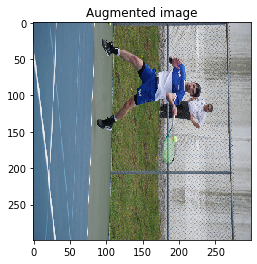

In [61]:
# Augment more images for Maksims to balance data set
# Each image will be horizontally and vertically flipped, 
# creating 2 additional images at time

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

augmented_image = []
augmented_label = []

for i in range(len(x_data)):
    if labelEncoder.inverse_transform([np.argmax(y_data[i])])[0] == "Maksims":
        augmented_image.append(h_flip(x_data[i]))
        augmented_label.append(y_data[i])
        augmented_image.append(v_flip(x_data[i]))
        augmented_label.append(y_data[i])
        
print(len(augmented_image), "new images was augmented")
plt.figure()
plt.title("Augmented image")
plt.imshow(augmented_image[20], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [62]:
# Append new data with previous

x_data = np.append(x_data, augmented_image, axis=0)
y_data = np.append(y_data, augmented_label, axis=0)

print("Shape of new data:",x_data.shape)

Shape of new data: (549, 299, 299, 3)


In [63]:
# Split data into train/validation/test folds (80-20-20)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=123)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=123)

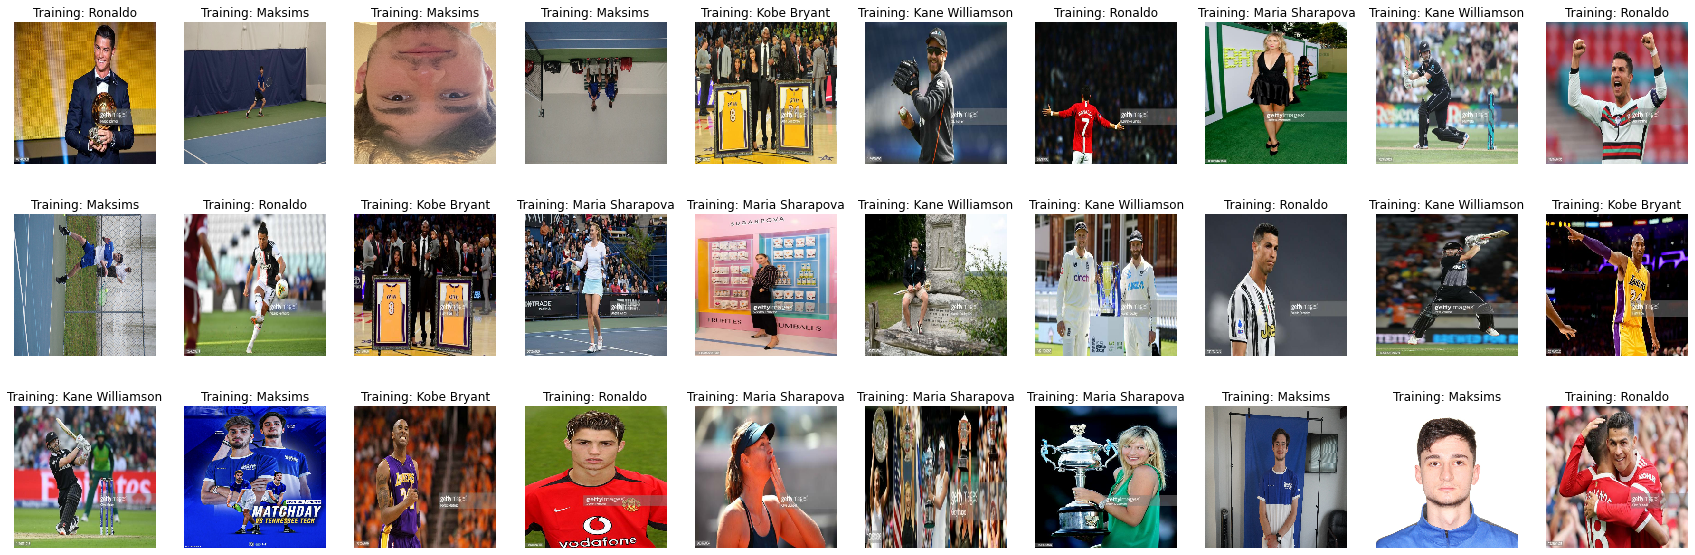

In [64]:
# Plot some training images

_, axes = plt.subplots(nrows=3, ncols=10, figsize=(30,10))
for i in range(len(axes)):
    for ax, image, label in zip(axes[i], x_train[i*10:i*10+10], 
                                y_train[i*10:i*10+10]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f'Training: {labelEncoder.inverse_transform([np.argmax(label)])[0]}')
plt.show()

In [65]:
# Prepare TF datasets

BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 20

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [66]:
pretrained_model = tf.keras.applications.Xception(include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
print("# of layers in Xception model:", len(pretrained_model.layers))

# of layers in Xception model: 132


In [67]:
# Define model
def make_model():
    # load model
    pretrained_model = tf.keras.applications.Xception(include_top = False, 
                                                      input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Make top 66 layers trainable
    for layer in pretrained_model.layers[:66]:
        layer.trainable = False
    for layer in pretrained_model.layers[66:]:
        layer.trainable = True
    
    # add more layers
    # dense layer with 5 neurons at the end with softmax activation function
    model = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation = 'relu', 
                                                       kernel_initializer = 'he_uniform'),
                                 tf.keras.layers.Dense(5, activation = 'softmax')])
    
    optimizer = tf.keras.optimizers.SGD(lr = 0.001, momentum = 0.9)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [68]:
Max_Xception = make_model()
Max_Xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               26214528  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 47,076,653
Trainable params: 41,073,437
Non-trainable params: 6,003,216
_________________________________________________________________


/Users/max/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [69]:
# Callbacks to reduce LR and save model with best validation lost

callbacks = [ReduceLROnPlateau(factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1),
             ModelCheckpoint('checkpoint.h5', verbose = 1, save_best_only = True)]

In [70]:
# Train model

model_history = Max_Xception.fit(train_dataset, 
                          epochs = 20, 
                          validation_data = val_dataset, 
                          callbacks = callbacks)

Epoch 1/20
21/21 [==============================] - 244s 11s/step - loss: 1.0417 - accuracy: 0.6079 - val_loss: 0.7451 - val_accuracy: 0.7455

Epoch 00001: val_loss improved from inf to 0.74512, saving model to checkpoint.h5


/Users/max/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
21/21 [==============================] - 193s 9s/step - loss: 0.1333 - accuracy: 0.9574 - val_loss: 0.3466 - val_accuracy: 0.8727

Epoch 00002: val_loss improved from 0.74512 to 0.34657, saving model to checkpoint.h5
Epoch 3/20
21/21 [==============================] - 187s 9s/step - loss: 0.0554 - accuracy: 0.9757 - val_loss: 0.4241 - val_accuracy: 0.8273

Epoch 00003: val_loss did not improve from 0.34657
Epoch 4/20
21/21 [==============================] - 192s 9s/step - loss: 0.0127 - accuracy: 0.9970 - val_loss: 0.2010 - val_accuracy: 0.9000

Epoch 00004: val_loss improved from 0.34657 to 0.20096, saving model to checkpoint.h5
Epoch 5/20
21/21 [==============================] - 188s 9s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2892 - val_accuracy: 0.8727

Epoch 00005: val_loss did not improve from 0.20096
Epoch 6/20
21/21 [==============================] - 186s 9s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2047 - val_accuracy: 0.9000

Epoch 00006: val

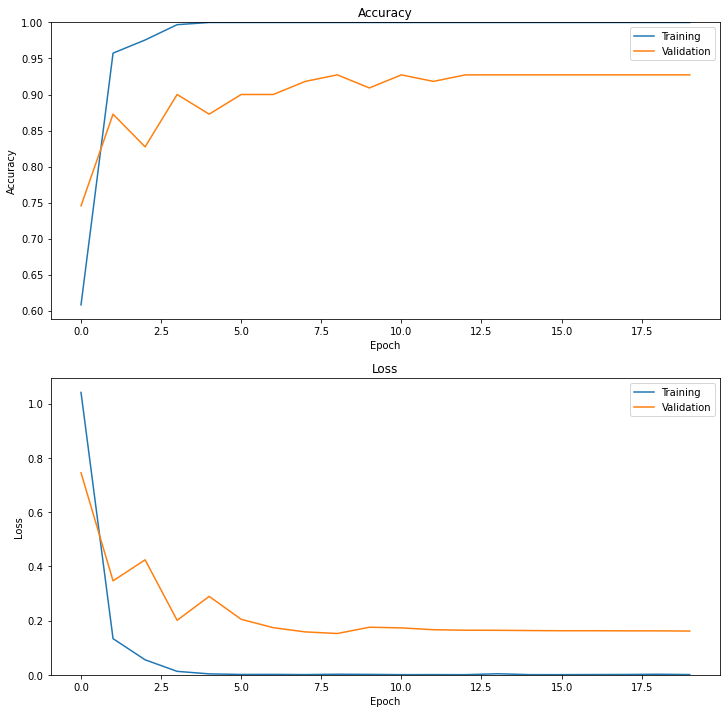

In [71]:
# Plots

train_accuracy = model_history.history['accuracy']
validation_accuracy = model_history.history['val_accuracy']

train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Training')
plt.plot(validation_accuracy, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Loss')
plt.show()

In [72]:
# Load best model and predict

final_model = tf.keras.models.load_model('checkpoint.h5')
pred = final_model.predict(x_test)

In [73]:
pred.shape

(110, 5)

In [74]:
predicted = []
ground_truth = []
for ind in range(len(pred)):
    predicted.append(np.argmax(pred[ind]))
    ground_truth.append(np.argmax(y_test[ind]))

In [75]:
predicted_labels = labelEncoder.inverse_transform(predicted)
truth_labels = labelEncoder.inverse_transform(ground_truth)

Text(0.5, 1.0, 'd')

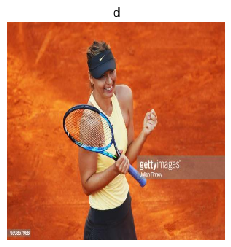

In [76]:
plt.imshow(x_test[6], cmap=plt.cm.gray_r, interpolation="nearest")
plt.axis('off')
plt.title("d")

In [77]:
print(f"Classification report for classifier:\n"
     f"{classification_report(truth_labels, predicted_labels)}\n")

print(f"----Model accuracy: {accuracy_score(truth_labels, predicted_labels)*100:.2f}%----")

Classification report for classifier:
                 precision    recall  f1-score   support

Kane Williamson       0.90      0.78      0.84        23
    Kobe Bryant       0.90      0.69      0.78        26
        Maksims       1.00      1.00      1.00        14
Maria Sharapova       0.85      1.00      0.92        22
        Ronaldo       0.77      0.92      0.84        25

       accuracy                           0.86       110
      macro avg       0.88      0.88      0.87       110
   weighted avg       0.87      0.86      0.86       110


----Model accuracy: 86.36%----


Confusion Matrix


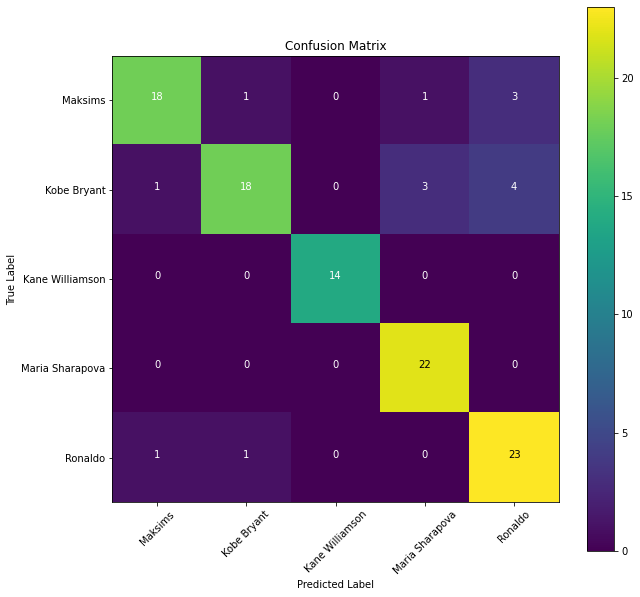

In [78]:
print("Confusion Matrix")
plt.figure(figsize=(10,10))
cm = confusion_matrix(truth_labels, predicted_labels)
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(unique_label))
plt.xticks(ticks, unique_label, rotation=45)
plt.yticks(ticks, unique_label)
thresh = cm.max()*0.8
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
            horizontalalignment="center",
            color="black" if cm[i,j] > thresh else "white")
    pass

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
pass


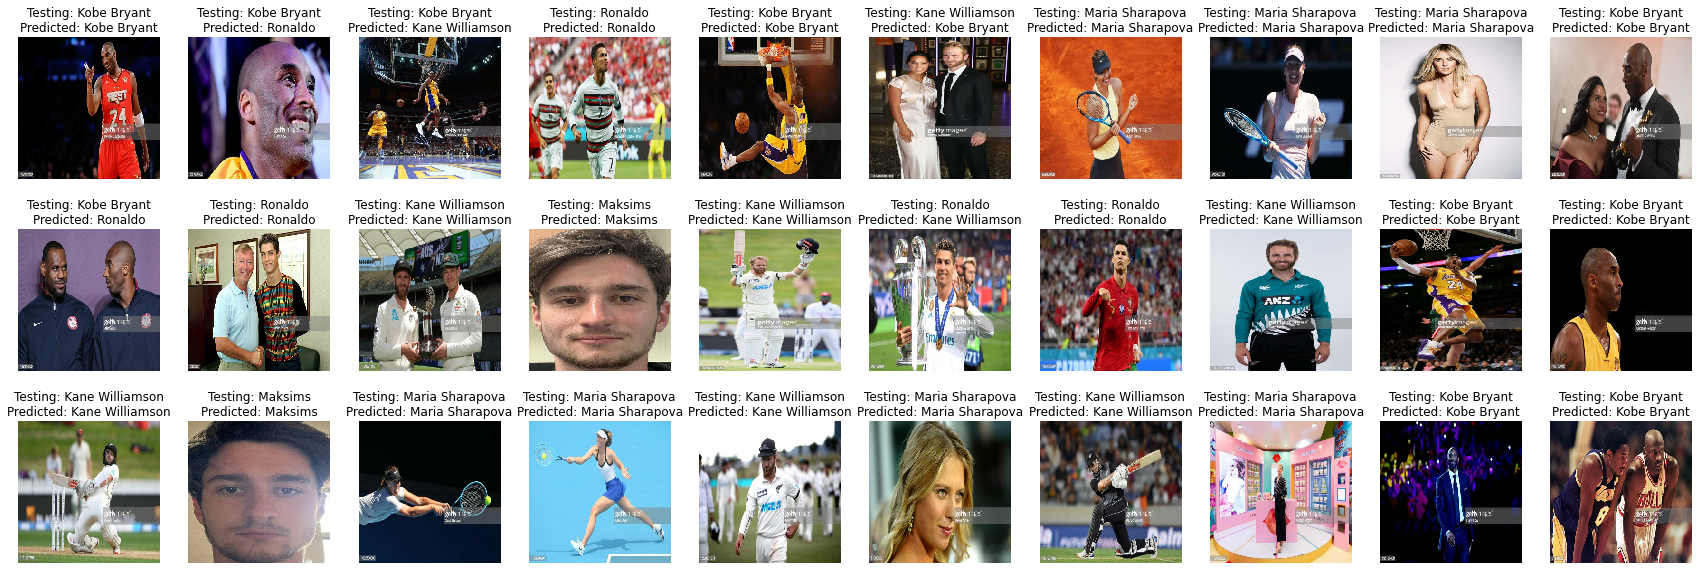

In [79]:
# Plot some images with predicted and truth labels

_, axes = plt.subplots(nrows=3, ncols=10, figsize=(30,10))
for i in range(len(axes)):
    for ax, image, label, predicted in zip(axes[i], x_test[i*10:i*10+10], 
                                truth_labels[i*10:i*10+10], predicted_labels[i*10:i*10+10]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f'Testing: {label}\nPredicted: {predicted}')
plt.show()